In [56]:
!pip install pytorch-transformers

In [0]:
import logging

import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm, trange

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch import optim
import torchtext

from pytorch_transformers import *


In [58]:
import os
os.environ['CUDA_VISBLE_DEVICES'] = '0'
use_cude = True

import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Found GPU at: /device:GPU:0


'Tesla K80'

# load data

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = pd.read_csv(r"/content/drive/My Drive/berkeley/no-complex-oversample.txt", header = None)

In [61]:
sentence_list = data[0][1:].values.tolist()

tag = data[2][1:].values.tolist()

tags2vals = list(set(tag))
tag2idx = {t: i for i, t in enumerate(tags2vals)}
print(tag2idx)

label = [tag2idx.get(l) for l in tag]

df1 = pd.DataFrame({'sentence':sentence_list, 'label':label})
headers = ['sentence', 'label']
df1.columns = headers

df1.to_csv("/content/drive/My Drive/berkeley/no-complex-oversample.csv")


{'PREVENT': 0, 'DISONLY': 1, 'VAGUE': 2, 'TREAT_NO_FOR_DIS': 3, 'TREAT_FOR_DIS': 4, 'TREATONLY': 5, 'SIDE_EFF': 6, 'NONE': 7}


In [0]:
text = torchtext.data.Field(lower=True, batch_first=True)
target = torchtext.data.Field(sequential=False, use_vocab=False, is_target=True)

train = torchtext.data.TabularDataset(path='/content/drive/My Drive/berkeley/no-complex-oversample.csv', format='csv',
                                      fields={'sentence': ('text',text),
                                              'label': ('target',target)})


In [63]:
text.build_vocab(train)

#load pre-trained embedding
text.vocab.load_vectors(torchtext.vocab.Vectors('/content/drive/My Drive/berkeley/dic_vec.txt'))

print(text.vocab.vectors.shape)

 99%|█████████▉| 10057/10156 [00:02<00:00, 3947.75it/s]


torch.Size([9963, 768])


In [0]:
random.seed(2018)
train, val = train.split(split_ratio=0.9, random_state=random.getstate())

In [65]:
print(len(train))
print(len(val))
train[2]

3229
359


In [0]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE('not majority', random_state=2018)
# train= smote.fit(train)


# from collections import Counter
# tr_tags = [tags2vals[p] for p in train]
# Counter(tr_tags)

# Model

In [0]:
class BiLSTM(nn.Module):
    def __init__(self, pretrained_lm, padding_idx, num_labels=8, static=True, hidden_dim=128, lstm_layer=2, dropout=0.2):
        super(BiLSTM, self).__init__()

        self.num_labels = num_labels
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(p=dropout)
        self.embedding = nn.Embedding.from_pretrained(pretrained_lm)
        self.embedding.padding_idx = padding_idx
        if static:
            self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(input_size=self.embedding.embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=lstm_layer, 
                            dropout = dropout,
                            bidirectional=True)
        self.hidden2label = nn.Linear(hidden_dim*lstm_layer*2, self.num_labels)

    
    def forward(self, sents, labels):
        x = self.embedding(sents)
        x = torch.transpose(x, dim0=1, dim1=0).to(dtype=torch.float32)
        
        lstm_out, (h_n, c_n) = self.lstm(x)
        logits = self.hidden2label(self.dropout(torch.cat([c_n[i,:, :] for i in range(c_n.shape[0])], dim=1)))
        outputs = (logits,) + (lstm_out, h_n)  # add hidden states and attention if they are here
        
        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = nn.MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs
        return outputs #loss, logits, lstm_out, h_n-lstm

In [0]:
batch_size = 128
train_iter = torchtext.data.BucketIterator(dataset=train,
                                               batch_size=batch_size,
                                               sort_key=lambda x: x.text.__len__(),
                                               shuffle=True,
                                               sort=False)
val_iter = torchtext.data.BucketIterator(dataset=val,
                                             batch_size=batch_size,
                                             sort_key=lambda x: x.text.__len__(),
                                             train=False,
                                             sort=False)
model = BiLSTM(text.vocab.vectors, num_labels=8, lstm_layer=2, padding_idx=text.vocab.stoi[text.pad_token], hidden_dim=128, static = False).cuda()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                    lr=1e-3)

In [69]:
import time
start = time.time()

val_loss_tt = []
val_acc_tt = []
train_loss_tt = []
f1_score_tt=[]


none = []
disonly = []
PREVENT = []
TREAT_FOR_DIS = []
TREAT_NO_FOR_DIS= []
VAGUE = []
SIDE_EFF = []
TREATONLY = []

CUDA_LAUNCH_BLOCKING=1 
train_loss_set = []

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)



# Number of training epochs (authors recommend between 2 and 4)
epochs = 20

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for train_batch in iter(train_iter):
    step =0
    
    # Add batch to GPU
    # Unpack the inputs from our dataloader
    x = train_batch.text.cuda()
    y = train_batch.target.type(torch.long).cuda()
    
    
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    
    # Forward pass

    outputs = model.forward(x, y)
  
    #print(outputs)
    loss, logits = outputs[:2]
    train_loss_set.append(loss)  

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient

    optimizer.step()
    optimizer.zero_grad()
    
    step += 1
    
    
    # Update tracking variables
    tr_loss += loss
    nb_tr_examples += x.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
  train_loss_tt.append(tr_loss/nb_tr_steps)
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss2, eval_accuracy2 = 0, 0
  nb_eval_steps2, nb_eval_examples2 = 0, 0
  predictions , true_labels = [], []

  # Evaluate data for one epoch
  for val_batch in iter(val_iter):
    
    
    
    # Add batch to GPU
    
    # Unpack the inputs from our dataloader
    val_x = val_batch.text.cuda()
    val_y = val_batch.target.type(torch.long).cuda()
    
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      ot = model.forward(val_x, None)
      logits = ot[0]
      outputs = model.forward(val_x, val_y)
      loss = outputs[0]
    
    # Move logits and labels to CPu
    
    m = nn.Softmax()
    pred = m(logits).to('cpu').detach().numpy()
    label_ids = val_y.to('cpu').numpy()
    
    predictions.extend([p for p in np.argmax(pred, axis=1)])
    true_labels.append(label_ids)
    
    
    tmp_eval_accuracy = flat_accuracy(pred, label_ids)
    #print(tmp_eval_accuracy)
    
    eval_accuracy2 += tmp_eval_accuracy
    nb_eval_steps2 += 1
    eval_loss2 += loss
    


  print("Validation loss: {}".format(eval_loss2/nb_eval_steps2))
  print("Validation Accuracy: {}".format(eval_accuracy2/nb_eval_steps2))
  pred_tags = [tags2vals[p] for p in predictions]
  valid_tags = [tags2vals[l_i] for l in true_labels for l_i in l]

    
  print('pred:', pred_tags)
  print('val:', valid_tags)
  print("F1-Score: {}".format(f1_score(pred_tags, valid_tags, average=None, labels=tags2vals)))

  f1 = f1_score(pred_tags, valid_tags, average=None, labels=tags2vals)

  val_loss_tt.append(eval_loss2/nb_eval_steps2)
  val_acc_tt.append(eval_accuracy2/nb_eval_steps2)
  f1_score_tt.append(sum(f1)/len(f1))


  none.append(f1[0])
  disonly.append(f1[1])
  PREVENT.append(f1[2])
  TREAT_FOR_DIS.append(f1[3])
  TREAT_NO_FOR_DIS.append(f1[4])
  VAGUE.append(f1[5])
  SIDE_EFF.append(f1[6])
  TREATONLY.append(f1[7])

end = time.time()
print('train time:', end - start)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
Epoch:   5%|▌         | 1/20 [00:02<00:46,  2.43s/it]

Train loss: 1.3417762517929077
Validation loss: 1.1243304014205933
Validation Accuracy: 0.5913480987055016
pred: ['NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE',

Epoch:  10%|█         | 2/20 [00:04<00:42,  2.35s/it]

Train loss: 1.060951590538025
Validation loss: 0.854011058807373
Validation Accuracy: 0.7257534385113269
pred: ['NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'DI

Epoch:  15%|█▌        | 3/20 [00:06<00:39,  2.33s/it]

Train loss: 0.8936305642127991
Validation loss: 0.7497385740280151
Validation Accuracy: 0.762768001618123
pred: ['NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'D

Epoch:  20%|██        | 4/20 [00:09<00:36,  2.28s/it]

Train loss: 0.7750014066696167
Validation loss: 0.6982685923576355
Validation Accuracy: 0.7874696601941747
pred: ['NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS

Epoch:  25%|██▌       | 5/20 [00:11<00:34,  2.27s/it]

Train loss: 0.6718481183052063
Validation loss: 0.6970865726470947
Validation Accuracy: 0.7784688511326862
pred: ['DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'TREATONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREATONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', '

Epoch:  30%|███       | 6/20 [00:13<00:31,  2.27s/it]

Train loss: 0.6348638534545898
Validation loss: 0.7102949023246765
Validation Accuracy: 0.7823371763754046
pred: ['DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'TREATONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', '

Epoch:  35%|███▌      | 7/20 [00:15<00:29,  2.27s/it]

Train loss: 0.5656028985977173
Validation loss: 0.623139500617981
Validation Accuracy: 0.7952821601941747
pred: ['DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'TREATONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREATONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', '

Epoch:  40%|████      | 8/20 [00:18<00:27,  2.28s/it]

Train loss: 0.5091652870178223
Validation loss: 0.6462404727935791
Validation Accuracy: 0.8070388349514563
pred: ['NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREATONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE'

Epoch:  45%|████▌     | 9/20 [00:20<00:25,  2.29s/it]

Train loss: 0.4828684329986572
Validation loss: 0.6425927877426147
Validation Accuracy: 0.7972542475728156
pred: ['DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY', 'TREA

Epoch:  50%|█████     | 10/20 [00:22<00:22,  2.27s/it]

Train loss: 0.43510857224464417
Validation loss: 0.632863461971283
Validation Accuracy: 0.7972542475728156
pred: ['NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREATONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NON

Epoch:  55%|█████▌    | 11/20 [00:24<00:20,  2.28s/it]

Train loss: 0.40789464116096497
Validation loss: 0.6839957237243652
Validation Accuracy: 0.8063309061488674
pred: ['NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREATONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONL

Epoch:  60%|██████    | 12/20 [00:27<00:18,  2.27s/it]

Train loss: 0.31592217087745667
Validation loss: 0.6886485815048218
Validation Accuracy: 0.7914138349514563
pred: ['DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'PREVENT', 'TREAT_FOR_DIS', 'PREVENT', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'TREATONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREATONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'P

Epoch:  65%|██████▌   | 13/20 [00:29<00:15,  2.28s/it]

Train loss: 0.29632434248924255
Validation loss: 0.8317710161209106
Validation Accuracy: 0.7778367718446603
pred: ['DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'SIDE_EFF', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'TREATONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'SIDE_EFF', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREATONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY

Epoch:  70%|███████   | 14/20 [00:31<00:13,  2.29s/it]

Train loss: 0.2757141590118408
Validation loss: 0.7130901217460632
Validation Accuracy: 0.8050667475728156
pred: ['NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'PREVENT', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREATONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS

Epoch:  75%|███████▌  | 15/20 [00:34<00:11,  2.28s/it]

Train loss: 0.20371638238430023
Validation loss: 0.7704375982284546
Validation Accuracy: 0.7940938511326862
pred: ['DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'PREVENT', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'VAGUE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREATONLY', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'DISONLY', 'DISONLY', 'NONE', 'NONE', 'TREAT_FO

Epoch:  80%|████████  | 16/20 [00:36<00:09,  2.28s/it]

Train loss: 0.19483354687690735
Validation loss: 0.787254810333252
Validation Accuracy: 0.7778367718446603
pred: ['DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'SIDE_EFF', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'PREVENT', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'TREATONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREATONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 

Epoch:  85%|████████▌ | 17/20 [00:38<00:06,  2.28s/it]

Train loss: 0.1473008394241333
Validation loss: 0.821382999420166
Validation Accuracy: 0.7746005258899676
pred: ['DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'PREVENT', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'VAGUE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_NO_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREATONLY', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'DISONLY', 'NONE', 'NONE', '

Epoch:  90%|█████████ | 18/20 [00:40<00:04,  2.27s/it]

Train loss: 0.11492365598678589
Validation loss: 0.9623519778251648
Validation Accuracy: 0.7888096682847897
pred: ['DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'PREVENT', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'TREATONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREATONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'TREA

Epoch:  95%|█████████▌| 19/20 [00:43<00:02,  2.28s/it]

Train loss: 0.10670362412929535
Validation loss: 1.1250799894332886
Validation Accuracy: 0.7998584142394822
pred: ['NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'PREVENT', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'TREATONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREATONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'DISONLY

Epoch: 100%|██████████| 20/20 [00:45<00:00,  2.27s/it]

Train loss: 0.07834857702255249
Validation loss: 0.9863638877868652
Validation Accuracy: 0.8024625809061489
pred: ['NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'PREVENT', 'TREAT_FOR_DIS', 'PREVENT', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREATONLY', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'TREAT_FOR_DIS', 'DISONLY', 'TREATONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'TREAT_FOR_DIS', 'DISONLY', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREAT_FOR_DIS', 'NONE', 'TREATONLY', 'TREAT_FOR_DIS', 'NONE', 'NONE', 'DISONLY', 'NONE', 'NONE', 'N

In [70]:
tags2vals

['PREVENT',
 'DISONLY',
 'VAGUE',
 'TREAT_NO_FOR_DIS',
 'TREAT_FOR_DIS',
 'TREATONLY',
 'SIDE_EFF',
 'NONE']

Text(0.5, 0, 'epochs')

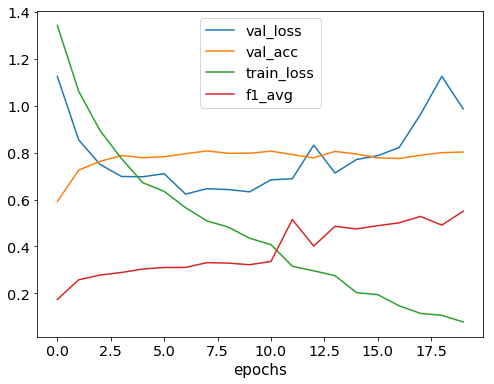

In [71]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.plot(range(epochs), val_loss_tt, label='val_loss')
plt.plot(range(epochs), val_acc_tt, label='val_acc')
plt.plot(range(epochs), train_loss_tt, label='train_loss')
plt.plot(range(epochs), f1_score_tt, label='f1_avg')
plt.legend()
plt.xlabel('epochs', fontsize=15)
# plt.savefig('/content/drive/My Drive/berkeley/sig+bilstm.png', dpi=500)

Text(0, 0.5, 'avg f1 score ')

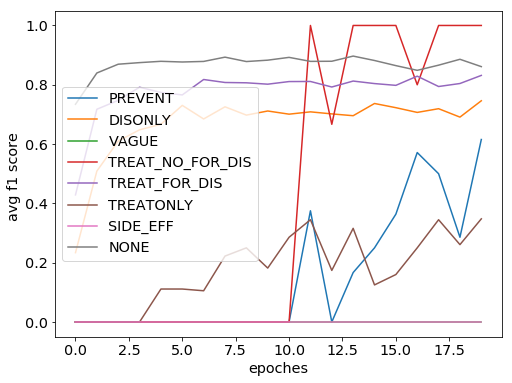

In [72]:

plt.plot(range(epochs), none, label='%s'%tags2vals[0])
plt.plot(range(epochs), disonly, label='%s'%tags2vals[1])
plt.plot(range(epochs), PREVENT, label='%s'%tags2vals[2])
plt.plot(range(epochs), TREAT_FOR_DIS, label='%s'%tags2vals[3])
plt.plot(range(epochs), TREAT_NO_FOR_DIS, label='%s'%tags2vals[4])
plt.plot(range(epochs), VAGUE, label='%s'%tags2vals[5])
plt.plot(range(epochs), SIDE_EFF, label='%s'%tags2vals[6])
plt.plot(range(epochs), TREATONLY, label='%s'%tags2vals[7])
plt.legend()
plt.xlabel('epoches')
plt.ylabel('avg f1 score ')

# plt.savefig('/content/drive/My Drive/berkeley/sig+bilstm2.png', dpi=500)

In [73]:
f1_score_tt[12]

0.4017621588907631